# The Great Heist of The National Gallery of Art
Andrew Hogan

CSPB 3287 - Final Project

YouTube: https://youtu.be/K9T0W046Y9Mhttps://youtu.be/K9T0W046Y9M

# Introduction

It's now time to pull off the greatest (fictional) art heist the world has ever seen! My target: The National Gallery of Art, which has housed thousands of art pieces across generations. I would love to decorate my space with some of this art, and I've figured out the perfect way to do it from my super top secret cat burglar van. 

My grand scheme includes measuring out the art, selecting the best wing in the gallery to attack, and stealthily removing the object from the database once I move the data into my own secret table.

***

I accomplish this grand feat using the following queries:

##### Setup
* Initialize tables using Python's sqlite3 and pandas modules
* Install "SQL Magic" via IPython for Jupyter Lab 
* Import CSV table data using pandas dataframes into my sqlite database file
* Construct an E/R Diagram detailing the relationships and foreign keys used between tables.

##### Query 1:
* JOIN objects table with objects_dimensions table to measure the art
* Use a CASE Statement to convert measurements, followed by a SUM aggregate to measure the total length of all art combined head-to-foot.

##### Query 2:
* Use several layers of subqueries to identify a location that could possibly be overlooked by security
* Count the number of rooms/unitpositions in the gallery, GROUP BY site.
* Use a left join to identify a locationid, then look for the object at that location.
* This query is not fruitful, but I have a backup plan in mind.

##### Query 3:
* Referring back to locations, and a brochure for a guided tour of a particular area of the museum, I determine the theme of the West Building's Main Floor.
* I identify a target: A painting by Leonardo da Vinci, using a subquery of the locations within the objects table.

##### Query 4:
* Construct my own `stolen_art` table operating with a foreign key constraint for the object id referencing the object in its own table.
* Develop triggers that delete the object from the objects and objects_dimensions table, and updates the art with data within my own table. 

### SETUP 

NGA Data is pulled from their GitHub Repo: https://github.com/NationalGalleryOfArt/opendatahttps://github.com/NationalGalleryOfArt/opendata

This is an ER Diagram detailing the relationships between the tables I will be using for this project. This is a modification of the ER Diagram used by the National Gallery of Art. 

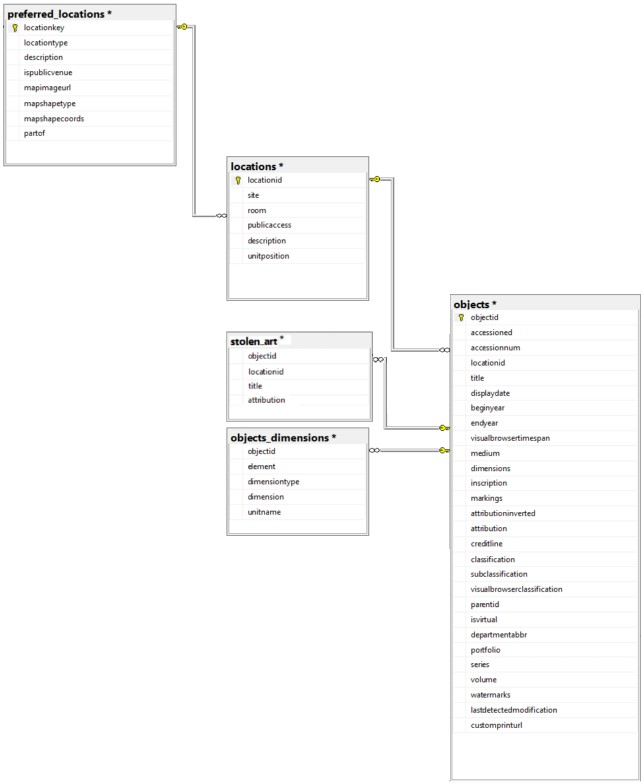

### Initiate this block on every run
This code block initializes a connection to the art database and a cursor object to allow for running setting up queries via `c.execute()`.

Later I've installed SQL Magic via IPython for Jupyter Lab and will switch to using that extension after setting up my tables here.

In [1]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('sqlite/db/nga.db')
c = conn.cursor()

### Drop All Tables
Code serves purpose of either printing out database schema, or dropping tables if needed.

In [2]:
c.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
for table in c.fetchall():
    print(table)
    c.execute(f"DROP TABLE {table[0]}")

('locations',)
('objects_dimensions',)
('objects',)
('preferred_locations',)
('stolen_art',)


### Construct Tables

Code below constructs the tables that will hold NGA data.

In [3]:
# Locations
c.execute("""CREATE TABLE IF NOT EXISTS locations
(
    locationID                  integer NOT NULL PRIMARY KEY,
    site                        character varying(64) NOT NULL,
    room                        character varying(64) NOT NULL,
    publicAccess                integer NOT NULL,
    description                 character varying(256) NOT NULL,
    unitPosition                character varying(64) NULL
);
""")

# Objects Dimensions
c.execute("""CREATE TABLE IF NOT EXISTS objects_dimensions
(
    objectID                    integer NOT NULL,
    element                     character varying(32) NOT NULL,
    dimensionType               character varying(32) NOT NULL,
    dimension                   decimal(22,10) NOT NULL,
    unitName                    character varying(32) NOT NULL,
        FOREIGN KEY (objectID) REFERENCES objects(objectID)
);
""")

# Objects
c.execute("""CREATE TABLE IF NOT EXISTS objects
(
    objectID                    integer NOT NULL PRIMARY KEY,
    accessioned                 integer NOT NULL,
    accessionNum                character varying(32) NULL,
    objectLeonardoID            character varying(16) NULL,
    locationID                  integer NULL,
    title                       character varying(2048) NULL,
    displayDate                 character varying(256) NULL,
    beginYear                   integer NULL,
    endYear                     integer NULL,
    visualBrowserTimeSpan       character varying(32) NULL,
    medium                      character varying(2048) NULL,
    dimensions                  character varying(2048) NULL,
    inscription                 character varying NULL,
    markings                    character varying NULL,
    attributionInverted         character varying(1024) NULL,
    attribution                 character varying(1024) NULL,
    creditLine                  character varying(2048) NULL,
    classification              character varying(64) NULL,
    subClassification           character varying(64) NULL,
    visualBrowserClassification character varying(32) NULL,
    provenanceText              character varying(2048) NULL,
    parentID                    integer NULL,
    isVirtual                   integer NOT NULL,
    departmentAbbr              character varying(32) NOT NULL,
    portfolio                   character varying(2048) NULL,
    series                      character varying(850) NULL,
    volume                      character varying(850) NULL,
    watermarks                  character varying(512) NULL,
    lastDetectedModification    timestamp with time zone NULL,
    customPrintURL              character varying(2048) NULL
);
""")


# Preferred Locations
c.execute("""CREATE TABLE IF NOT EXISTS preferred_locations
(
    locationKey                 character varying(32) NOT NULL,
    locationType                character varying(32) NOT NULL,
    description                 character varying(512) NOT NULL,
    isPublicVenue               integer NOT NULL,
    mapImageURL                 character varying(1024) NULL,
    mapShapeType                character varying(32) NULL,
    mapShapeCoords              character varying(1024) NULL,
    partof                      character varying(32)
);
""")

### Import CSV into Tables

I use Pandas to construct dataframe objects to then import into my newly made tables.

In [4]:
df = pd.read_csv('sqlite/db/data/locations.csv')
df.to_sql('locations', conn, if_exists='append', index=False)

df = pd.read_csv('sqlite/db/data/preferred_locations.csv')
df.to_sql('preferred_locations', conn, if_exists='append', index=False)

df = pd.read_csv('sqlite/db/data/objects.csv', low_memory=False)
df.to_sql('objects', conn, if_exists='append', index=False)

df = pd.read_csv('sqlite/db/data/objects_dimensions.csv')
df.to_sql('objects_dimensions', conn, if_exists='append', index=False)

208677

### Load SQL Magic and Database

I have installed SQL Magic using the IPython package for Jupyter Lab. I load it and my database here.

In [5]:
%reload_ext sql
%sql sqlite:////Users/andre/sqlite/db/nga.db

And now I'm ready to begin my heist of the NGA.

## QUERY 1: How Tall is the Objet d'art?

I want to make sure that my top secret van will fit as much as possible... or as much art as I can get away with.

How much art are we dealing with?

Let's get a look at a few of the selections as well as how much art is present in the database. (I `LIMIT` and make provenance text NULL here to save visuals).

In [6]:
%%sql
SELECT *
FROM objects
WHERE provenancetext IS NULL
LIMIT 1;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,accessioned,accessionNum,objectLeonardoID,locationID,title,displayDate,beginYear,endYear,visualBrowserTimeSpan,medium,dimensions,inscription,markings,attributionInverted,attribution,creditLine,classification,subClassification,visualBrowserClassification,provenanceText,parentID,isVirtual,departmentAbbr,portfolio,series,volume,watermarks,lastDetectedModification,customPrintURL
540,1,1939.2.1,None,None,"Perugino's Udienza del Cambio in the Collegio del Cambio, Perugia",1896,1896,1896,1876 to 1900,graphite,overall: 33 x 48.3 cm (13 x 19 in.),"lower right in graphite: Peruginos Udienza del Cambio in the Collegio del Cambio Perugia. / Wood work by Dom. del. Tasso. 1490-93. / Drawn to scale. 3/8 = 1 foot. Aug 11 96.; uR //in graphite, circled: 1; uCv//in blue pencil: Pencil Point- / Fig 13",None,"Pope, John Russell",John Russell Pope,Gift of Mrs. John Russell Pope,Drawing,None,drawing,None,None,0,CG-W,Architectural Studies,Architectural Studies,None,None,2020-03-17 22:01:55.143-04,None


In [7]:
%%sql
SELECT COUNT(*)
FROM objects;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


COUNT(*)
137635


That's a lot of objects and data! It's also odd that some `locationid`'s are `None`. A `NULL` `locationid` indicates that the object is not currently on display, and this could be for any number of reasons. In fact, the database contains a value for every art object that has ever graced the halls of the NGA! It is entirely possible that some of these objects are not even inside at the present time. Therefore, we're only interested in those objects that are currently on display to know for certain that they are inside. 

So, I will search for objects that have locationID's.

In [8]:
%%sql
SELECT COUNT(*)
FROM objects
WHERE locationid NOT NULL;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


COUNT(*)
2597


That's a more realistic number, and definitely plenty for me to get my hands on! 

There's also data on the size of this art, found in the `objects_dimensions` table.

In [9]:
%%sql
SELECT *
FROM objects_dimensions
LIMIT 4;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,element,dimensionType,dimension,unitName
8,painted surface,width,33,centimeters
8,painted surface,height,89.2,centimeters
14,overall,width,46,centimeters
14,overall,height,105,centimeters


In [10]:
%%sql
SELECT DISTINCT dimensiontype, unitname
FROM objects_dimensions;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


dimensionType,unitName
width,centimeters
height,centimeters
depth,centimeters
diameter,centimeters
height,inches
width,inches
(not specified),(not specified)
weight,pounds
weight1,grams
diameter,inches


It appears plenty of the art comes with a measurement of height and width, but some objects, like busts and statues, would come with a weight measurement as well.

Also, these measurements are a collection of *all* the art that has ever appeared in the NGA. We need to combine the `objects` and `objects_dimensions` tables on the `objectID` and ensure the piece is on display within the museum.

In [11]:
%%sql
SELECT o.objectid, o.title, od.*
FROM objects o
JOIN objects_dimensions od ON o.objectID = od.objectID
WHERE o.locationID NOT NULL
LIMIT 10;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,title,objectID_1,element,dimensionType,dimension,unitName
8,Saint Venantius [right panel],8,painted surface,width,33,centimeters
8,Saint Venantius [right panel],8,painted surface,height,89.2,centimeters
14,Claudia Quinta,14,overall,width,46,centimeters
14,Claudia Quinta,14,overall,height,105,centimeters
15,The Adoration of the Magi,15,overall,width,46.4,centimeters
15,The Adoration of the Magi,15,overall,height,26.9,centimeters
19,Portrait of a Man,19,painted surface,width,40.4,centimeters
19,Portrait of a Man,19,painted surface,height,54.2,centimeters
20,The Adoration of the Child,20,painted surface,width,56.3,centimeters
20,The Adoration of the Child,20,painted surface,height,81.5,centimeters


By the look of it, everything contains a height and a width. We first need to find a unit of measurement to agree upon, since it appears both inches and centimeters are used. 1 inch = 2.54 centimeters

Our next task is to convert the units to centimeters where height and width are in inches.

In [12]:
%%sql
SELECT o.objectid, o.title, od.dimensiontype Dimension, od.unitname Units, 
    CASE 
    WHEN od.unitname == 'inches' THEN od.dimension*2.54
    WHEN od.unitname == 'centimeters' THEN od.dimension
    END as Measure
FROM objects o
JOIN objects_dimensions od ON o.objectID = od.objectID
WHERE o.locationID NOT NULL
LIMIT 10;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,title,Dimension,Units,Measure
8,Saint Venantius [right panel],width,centimeters,33
8,Saint Venantius [right panel],height,centimeters,89.2
14,Claudia Quinta,width,centimeters,46
14,Claudia Quinta,height,centimeters,105
15,The Adoration of the Magi,width,centimeters,46.4
15,The Adoration of the Magi,height,centimeters,26.9
19,Portrait of a Man,width,centimeters,40.4
19,Portrait of a Man,height,centimeters,54.2
20,The Adoration of the Child,width,centimeters,56.3
20,The Adoration of the Child,height,centimeters,81.5


Interesting! Now that we've converted the measurement of our objects, if we stacked each object end to end, how tall would this Tower of 'Objet d'art' be? You know... for science!

In [13]:
%%sql
SELECT od.dimensiontype Dimension, od.unitname Units, 
    SUM(CASE 
    WHEN od.unitname == 'inches' THEN od.dimension*2.54
    WHEN od.unitname == 'centimeters' THEN od.dimension
    END) as Measure
FROM objects o
JOIN objects_dimensions od ON o.objectID = od.objectID
WHERE o.locationID NOT NULL AND od.dimensiontype = 'height'
LIMIT 10;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


Dimension,Units,Measure
height,centimeters,164445.31514043824


So, converting to other relatable measurements, that's...

In [14]:
TowerOfArtSize = 164445.31514043824
print(TowerOfArtSize/10000, "kilometers")
print((TowerOfArtSize/10000)*0.62, "miles")

16.444531514043824 kilometers
10.19560953870717 miles


That's a whole lotta art!

Hmm... All of this art seems a tad... big for my top secret cat burglar van. But I guess that would be the case if I was intending on heisting the entire joint. But maybe I can get away with only a few pieces. I'll just have to take my pick!

## QUERY 2: Location, Location, Location

What kinds of art are featured within each location? I might want to stick to a theme when I decorate my apartment, shortly.

Let's see what kinds of locations are featured in the `locations` table.

In [15]:
%%sql
SELECT DISTINCT(site)
from locations;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


site
East Building
West Building
Sculpture Garden (WSG)


There's an East and a West building, as well as a scultpure garden in the center. 

Though a sculpture would be a really exotic piece to host in my apartment, perhaps I need to select something a little more discreet.

How many rooms are in each section?

In [16]:
%%sql
SELECT site, COUNT(room)
FROM locations
GROUP BY site;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


site,COUNT(room)
East Building,308
Sculpture Garden (WSG),4
West Building,760


There are about 2.5x as many rooms in the West Building as there are the East... or are there?

If we look at at the `locations` schema again, there appears to be about 3-5 different unit positions within each room. Theoretically, a room contains a number of objects up to the number of unit positions within each room:

In [17]:
%%sql
SELECT locationid, site, room, description, unitposition
FROM locations
ORDER BY locationid
LIMIT 9;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID,site,room,description,unitPosition
3591,East Building,EBL,East Bldg Lawn,None
3592,East Building,EBL,East Bldg Lawn,E
3593,East Building,EBL,East Bldg Lawn,S
3594,East Building,EBL,East Bldg Lawn,W
3680,East Building,EC-028,"East Bldg, Concourse Gallery Lobby",None
3681,East Building,EC-028,"East Bldg, Concourse Gallery Lobby",E
3682,East Building,EC-028,"East Bldg, Concourse Gallery Lobby",N
3683,East Building,EC-028,"East Bldg, Concourse Gallery Lobby",S
3684,East Building,EC-028,"East Bldg, Concourse Gallery Lobby",W


Maybe I will want to aim for a place a little less conspicuous. As much as I would love to have the popular art hanging on my wall... it would probably be greatly missed and have the highest amount of exposure in the news.

The `preferred_locations` table features many of the most advertised parts of the museum in a brochure distributed monthly. Maybe I wouldn't be able to get away with taking some of the featured content, but perhaps I could snag something less in the spotlight.

We can combine the `locations` and `preferred_locations` tables on `locations.room = preferred_locations.locationkey`. Then, I'll want to narrow down to the locations *not* featured in the brochure.

In [18]:
%%sql
SELECT l.locationid, l.site, l.description, l.room, pl.locationkey
FROM locations l
JOIN preferred_locations pl ON l.room = pl.locationkey
LIMIT 10;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID,site,description,room,locationKey
3591,East Building,East Bldg Lawn,EBL,EBL
3592,East Building,East Bldg Lawn,EBL,EBL
3593,East Building,East Bldg Lawn,EBL,EBL
3594,East Building,East Bldg Lawn,EBL,EBL
3680,East Building,"East Bldg, Concourse Gallery Lobby",EC-028,EC-028
3681,East Building,"East Bldg, Concourse Gallery Lobby",EC-028,EC-028
3682,East Building,"East Bldg, Concourse Gallery Lobby",EC-028,EC-028
3683,East Building,"East Bldg, Concourse Gallery Lobby",EC-028,EC-028
3684,East Building,"East Bldg, Concourse Gallery Lobby",EC-028,EC-028
3809,East Building,"East Bldg, Central Atrium",EG-100,EG-100


Now that we have a query revealing all the locations within the preferred locations, how do we find all those locations that are *not* in this table?

In other words, which locations are present in the `locations` table that are NOT present in `preferred_locations`? **(*A-B*)**

I'll use a Left Join here and select where the other key is NULL.

In [19]:
%%sql
SELECT *
FROM locations l
LEFT JOIN preferred_locations pl ON l.room = pl.locationkey
WHERE pl.locationkey IS NULL

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID,site,room,publicAccess,description,unitPosition,locationKey,locationType,description_1,isPublicVenue,mapImageURL,mapShapeType,mapShapeCoords,partof
3971,East Building,EST,1,"East Bldg, South Terrace",None,None,None,None,None,None,None,None,None


I can also perform a similar operation like the one above using a subquery.

In [20]:
%%sql
SELECT *
FROM locations
WHERE room NOT IN(
SELECT locationkey
FROM preferred_locations)

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID,site,room,publicAccess,description,unitPosition
3971,East Building,EST,1,"East Bldg, South Terrace",None


Interesting that one location isn't featured in the brochure. Is there something here?

In [21]:
%%sql
SELECT objectid, locationid, title, attribution
FROM objects
WHERE locationid IN (SELECT locationid
FROM locations l
LEFT JOIN preferred_locations pl ON l.room = pl.locationkey
WHERE pl.locationkey IS NULL
)

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,locationID,title,attribution


Shoot! It appears nothing is here. Looks like I'll have to aim for something a little riskier. This is art, after all. Go big or go home!

## QUERY 3: Convincing Da Vinci

There appears to be several guided tours going on over the next several days, particularly an Italian Rennaisance Tour in the West Building. Molto bella! This would be the perfect time to scope out what is available for looting.

I'll get a background of the scene by looking at the `site` and `description` attributes in the `locations` table to locate the art. Given the description of the guided tour, it appears the Italian art is featured on the Main Floor. 

First, I'll query up the `locationID`'s of the West Building, Main Floor. (I `LIMIT` here only because the list is long. I omit the limit next.)

In [22]:
%%sql
SELECT locationid
FROM locations
WHERE site='West Building' AND description LIKE '%Main Floor%'
LIMIT 5;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID
8191
8192
8193
8194
8195


Then, I'll search for art having a locationID within this set using a subquery.

In [23]:
%%sql
SELECT locationid, objectid, title, attribution
FROM objects
WHERE locationid IN
(
SELECT locationid
FROM locations
WHERE site='West Building' AND description LIKE '%Main Floor%'
)
LIMIT 20

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID,objectID,title,attribution
8197,1,Saint Paul and a Group of Worshippers,Bernardo Daddi
8198,2,Saint Andrew and Saint Benedict with the Archangel Gabriel [left panel],Agnolo Gaddi
8198,3,"Madonna and Child Enthroned with Twelve Angels, and with the Blessing Christ [middle panel]",Agnolo Gaddi
8198,4,Saint Bernard and Saint Catherine of Alexandria with the Virgin of the Annunciation [right panel],Agnolo Gaddi
8207,5,The Madonna of Humility,Fra Angelico
8203,6,Saint Anthony Abbot [left panel],Puccio di Simone and Allegretto Nuzi
8203,7,Madonna and Child Enthroned with Four Saints and Eighteen Angels [middle panel],Puccio di Simone and Allegretto Nuzi
8203,8,Saint Venantius [right panel],Puccio di Simone and Allegretto Nuzi
8229,11,Madonna and Child with Angels and Cherubim,Matteo di Giovanni
8229,12,The Adoration of the Magi,Benvenuto di Giovanni


There's a piece by Leonardo da Vinci! Since I'm such a Leo fan, I only want to target art that is attributed to him under the `attribution` attribute (phew...).

In [24]:
%%sql
SELECT locationid, objectid, title, attribution
FROM objects
WHERE locationid IN
(
SELECT locationid
FROM locations
WHERE site='West Building' AND description LIKE '%Main Floor%'
) AND attribution = 'Leonardo da Vinci'

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


locationID,objectID,title,attribution
9017,50724,Ginevra de' Benci [obverse],Leonardo da Vinci
9017,50725,"Wreath of Laurel, Palm, and Juniper with a Scroll inscribed Virtutem Forma Decorat [reverse]",Leonardo da Vinci


Oh my... am I actually considering targetting the NGA's featured art? It would certainly make national acclaim, causing the value of this art to skyrocket. Perhaps I'll be bold and take a chance. After all, it is a lovely painting: https://www.nga.gov/collection/highlights/da-vinci-ginevra-de-benci.html

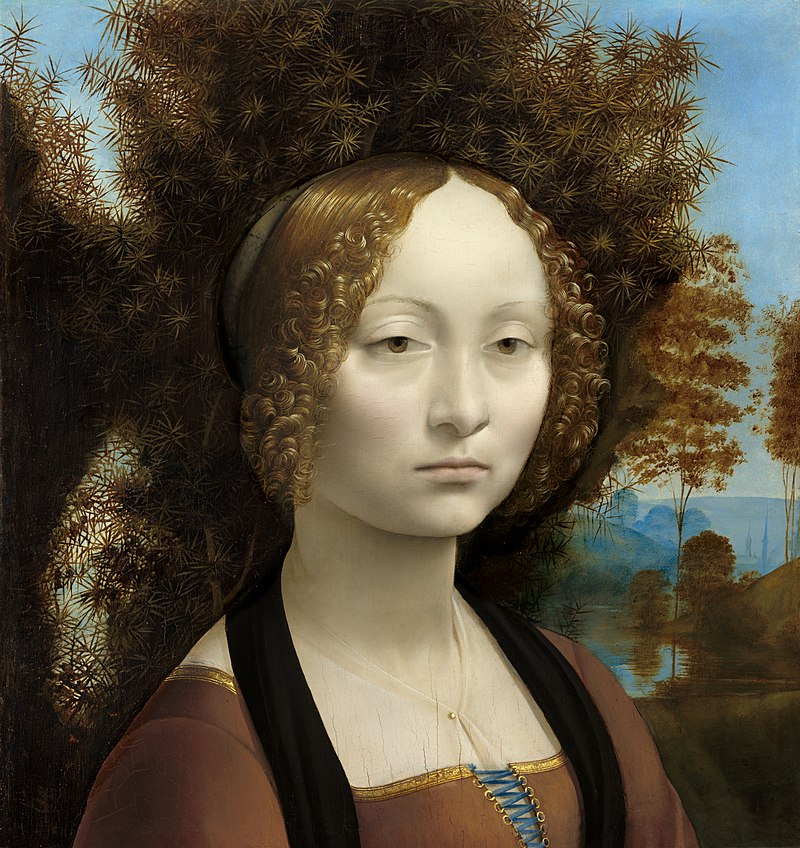

In [25]:
from IPython import display
display.Image("https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Leonardo_da_Vinci_-_Ginevra_de%27_Benci_-_Google_Art_Project.jpg/800px-Leonardo_da_Vinci_-_Ginevra_de%27_Benci_-_Google_Art_Project.jpg")

## Query 4: Escaping in my Getaway Database

Now that I have the art in hand, I need to make sure the database watchers don't notice my five-fingered handiwork. I need to hack the system and ensure that when I transfer the art data to my database that it removes the essential parts of the art from theirs. In other words, now that I have the art in hand, the art in the `objects` table needs to be updated to reflect that it is no longer on display, i.e. the `locationID` of the object needs to be set to `NULL`.

I'll begin by initializing a new table to store the essential object data. I seek to store the objectID, it's previous locationID, the title of the art and who it is attributed to, and my own primary collection ID to maintain my own collection.

In [26]:
%%sql
CREATE TABLE IF NOT EXISTS stolen_art
(
    objectid                    integer NOT NULL,
    locationid                  integer NULL,
    title                       character varying(2048) NULL,
    attribution                 character varying(1024) NULL,
        FOREIGN KEY (objectid) REFERENCES objects(objectid)
);

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


[]

Next, we remind ourselves of the locationid of the art we're looking to heist. The Ginevra is who we're after, and we want its data present within my `stolen_art` table.

In [27]:
%%sql
SELECT objectid, locationid, title, attribution
FROM objects
WHERE attribution LIKE '%Leonardo da Vinci%' AND title LIKE 'Ginevra%'

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,locationID,title,attribution
50724,9017,Ginevra de' Benci [obverse],Leonardo da Vinci


After inserting the appropriate objectid there, we want to ensure the artwork has truly "disappeared" by setting its `locationid` to `NULL` in the `objects` table. It'll be as if it were never there!

I'll construct a trigger statement that will delete the art with corresponding `objectid` and delete the object from other tables, like `objects_dimensions`.

In [28]:
%%sql
DROP TRIGGER IF EXISTS remove_object;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


[]

In [29]:
%%sql
CREATE TRIGGER IF NOT EXISTS remove_object
AFTER INSERT ON stolen_art
FOR EACH ROW
BEGIN
    UPDATE objects SET locationid = NULL
    WHERE objectID = new.objectID;
    DELETE FROM objects
    WHERE objectID = new.objectID;
    DELETE FROM objects_dimensions
    WHERE objectID = new.objectID;
END;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


[]

It's time to move the data over. I'll simply `INSERT` the data of the object into my `stolen_art` table, and the trigger should do the rest.

In [30]:
%%sql
INSERT INTO stolen_art(objectid, locationid, title, attribution)
SELECT objectid, locationid, title, attribution
FROM objects
WHERE attribution LIKE '%Leonardo da Vinci%' AND title LIKE 'Ginevra%';

 * sqlite:////Users/andre/sqlite/db/nga.db
1 rows affected.


[]

Did it work? Let's check the table again using the same query as above.

In [31]:
%%sql
SELECT *
FROM stolen_art;

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectid,locationid,title,attribution
50724,9017,Ginevra de' Benci [obverse],Leonardo da Vinci


In [32]:
%%sql
SELECT objectid, locationid, title, attribution
FROM objects
WHERE attribution LIKE '%Leonardo da Vinci%' AND title LIKE 'Ginevra%'

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,locationID,title,attribution


In [33]:
%%sql
SELECT *
FROM objects_dimensions
WHERE objectid = 50724

 * sqlite:////Users/andre/sqlite/db/nga.db
Done.


objectID,element,dimensionType,dimension,unitName


By the time they notice, I'll be long gone and have a fancy lady looking over my apartment space ;)

Thank you for taking the time to review my work, I hope you had a fun time reading and heisting some art with me. Cheers!